In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import pandas as pd

## Janine Birnbaum 

June 2019

Read flow data from video files and still images and compare with model.

In [2]:
# Shortcut functions for trigonometric functions in degrees

def sind(theta):
    """Calculate sine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Sine value.
    
    """
    
    return np.sin(np.deg2rad(theta))

def cosd(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.cos(np.deg2rad(theta))

def tand(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.tan(np.deg2rad(theta))

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [3]:
def damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i):
    
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space for on an inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2))      - Evaluation points in x [m].
     - *h0*    (ndarray(m+2))      - Initial height at evaluation points in x [m].
     - *theta* (float)             - Slope [deg].
     - *rho*   (float)             - Fluid density [kg/m^3].
     - *K*     (float)             - Fluid consistency [Pa s].     
     - *tauy*  (float)             - Yield stress [Pa].
     - *n*     (float)             - Rheology power law exponent.
     - *g*     (float)             - Gravitational constant [m/s^2].
     - *ts*    (float)             - Final time for simulation [sec].
     - *i*     (int)               - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
    """

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = ts/(i+1)
    t = np.linspace(0, ts, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))    
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = sind(theta) - cosd(theta)*(h[k+j,2:] - h[k+j,1:-1])/dx[1:]
            hxl = sind(theta) - cosd(theta)*(h[k+j,1:-1] - h[k+j,:-2])/dx[:-1]
            Yr  = hr - tauy/(rho*g*np.abs(hxr))
            Yl  = hl - tauy/(rho*g*np.abs(hxl))
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
        
            Qr = n*((np.abs(hxr))**(1/n-1)*(Yr)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hr - n*Yr)*hxr
            Ql = n*((np.abs(hxl))**(1/n-1)*(Yl)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hl - n*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            h[k+1,1:-1] = h[k,1:-1] - s*dt/dx[:-1]*(rho*g/K)**(1/n)*(Qr - Ql)
            
            # Boundary conditions
            h[k+1,0] = h[k+1,1]
    
    return h, t

## Comparison to experimental data

Import video of experimental data and find the flow front through time:

In [119]:
# Change these parameters

startFrame = 0
endFrame = 750

# RGB channel and threshold for front picking
thresh = 150
channel = 2 #1 = Red, 2 = Green, 3 = Blue

# Video file
filedir = # path to file
filename = # file name

# manually set starting location, line for analysis
# black in next figure
x0 = 468 # pixels
yline = 1200

# crop image
top = 900
bottom = 1500

title_str = 'Validation'

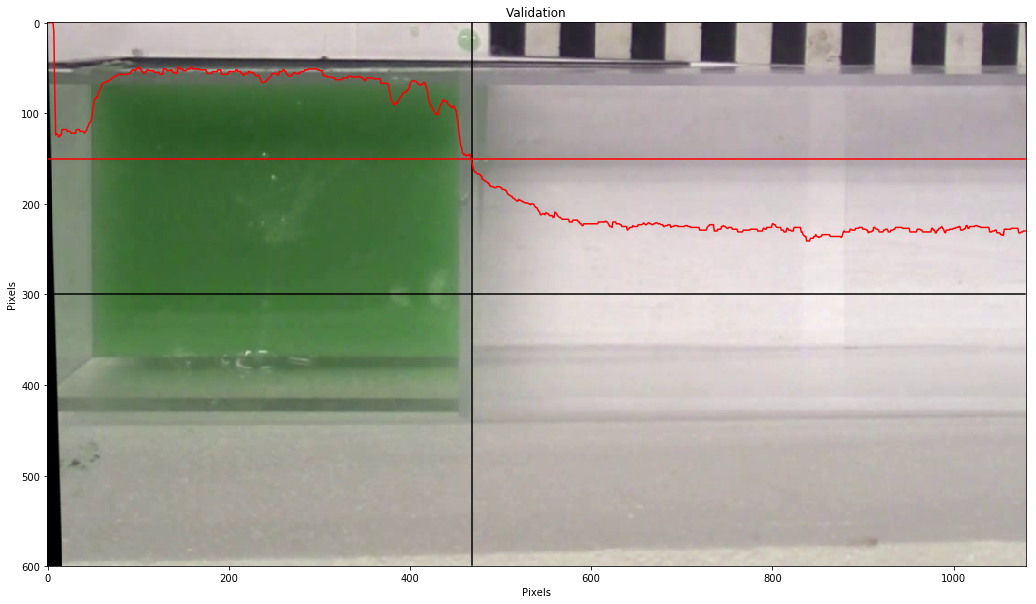

In [116]:
y2 = bottom - top - 1

# read first frame from video
cap = cv2.VideoCapture(filedir +  filename)
fps = cap.get(cv2.CAP_PROP_FPS)

ret, frame = cap.read()
if ret:
    pic = np.flip(frame,2)
    pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
cap.release()

# plot cropped image, profile for analysis
# x0 and yline in black
# threshold and profile along yline in red
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(pic[top:bottom,:,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([0, pic.shape[1]-1], [yline-top, yline-top], 'k')
ax.plot(pic[yline,:,channel], 'r')
ax.plot([0, pic.shape[1]-1], [thresh, thresh], 'r')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title(title_str);

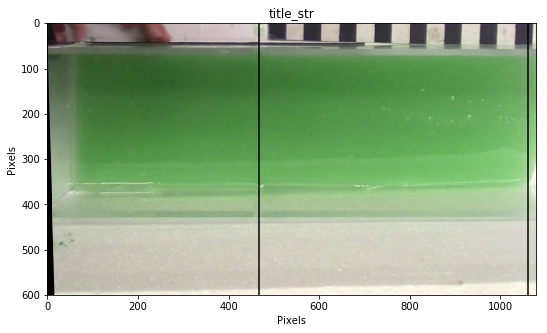

In [120]:
currentFrame = 0

y2 = bottom - top - 1

# read video from start to end frame
cap = cv2.VideoCapture(filedir +  filename)
fps = cap.get(cv2.CAP_PROP_FPS)
pos = np.zeros(endFrame-startFrame)

while(currentFrame<endFrame):
    ret, frame = cap.read()
    if currentFrame >= startFrame:
        if ret:
            pic = np.flip(frame,2)
            pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
            pos[currentFrame - startFrame] = np.max(np.where(pic[yline,:,channel]<thresh))
    
    currentFrame += 1
    
cap.release()

# plot final frame
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(pic[top:bottom,:,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([pos[-1], pos[-1]], [0, y2], 'k')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('title_str');

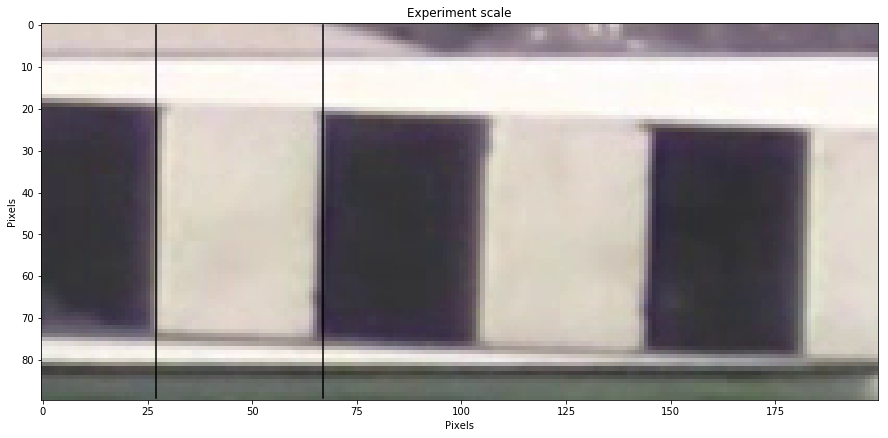

In [30]:
# Calculate image scale
# Crop image
top2 = 860
bottom2 = 950
left2 = 500
right2 = 700

# Plot
fig,ax = plt.subplots(figsize=(15,20))
ax.imshow(pic[top2:bottom2,left2:right2,:])

# Set to align with one 2cm segment on scale
lft = 27
rgt = 67

# Plot
ax.plot([lft, lft], [0, bottom2-top2-1], 'k')
ax.plot([rgt, rgt], [0, bottom2-top2-1], 'k')

# Determine scaling factors
W = 0.02 # m
k = W/(rgt-lft) # m/pixel
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Experiment scale');

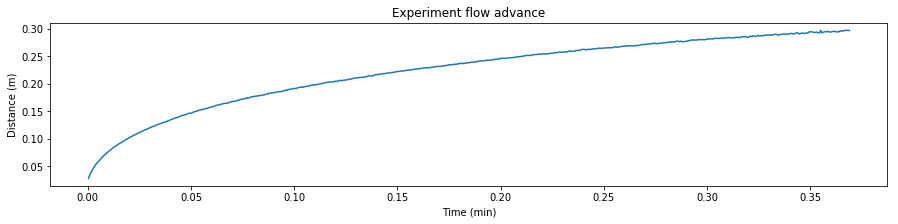

In [126]:
# scale time and front position
pos_scaled = (pos-x0)*k
pos_scaled[pos_scaled<0] = 0
t_scaled = np.arange((pos_scaled).size)/fps

t0 = 2.85 # Time of dam release [sec]

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot((t_scaled[t_scaled>t0]-t0)/60, pos_scaled[t_scaled>t0])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

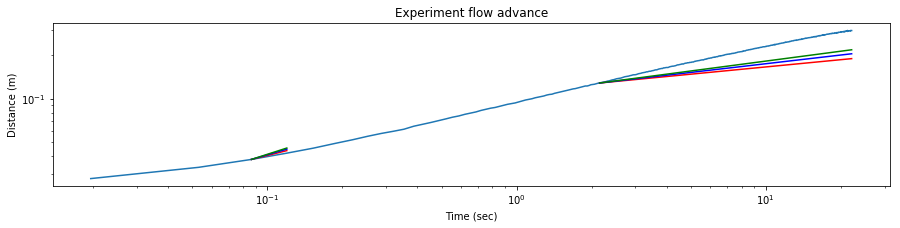

In [129]:
# Plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.loglog((t_scaled[t_scaled>t0]-t0), pos_scaled[t_scaled>t0])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

# Find expected n graphically
c = ['r','b','g']

t1 = 88
t2 = 90
t3 = -600

for  j,n in enumerate(np.linspace(0.75,1.25,3)):
    color = c[j]
    y1 = pos_scaled[t1]/(t_scaled[t1]-t0)**(n/(n+1))
    y2 = pos_scaled[t3]/(t_scaled[t3]-t0)**(n/(2*n+3))
    ax.loglog(t_scaled[t1:t2]-t0, y1 * (t_scaled[t1:t2]-t0)**(n/(n+1)),Color=color)
    ax.loglog(t_scaled[t3:]-t0, y2 * (t_scaled[t3:]-t0)**(n/(2*n+3)),Color=color)

10.115648753869133 0.9790256219608229


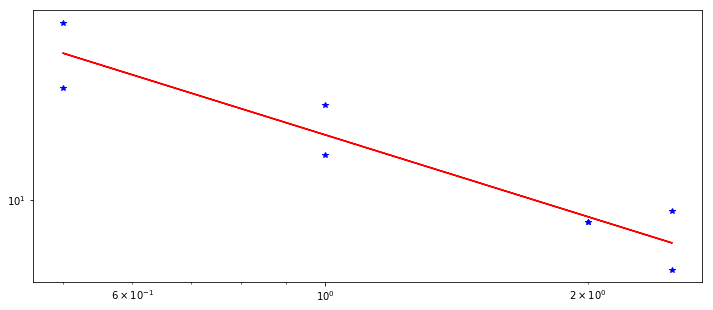

In [114]:
# Viscometer Data

RPM = np.array([0.5, 1, 2, 2.5, 2.5, 2, 1, 0.5])
Pas = np.array([10.32, 10.08, 9.96, 9.876, 9.9792, 9.96, 10.17, 10.2])

m,b = np.polyfit(np.log(RPM), np.log(Pas), 1)
K = np.exp(b)
n = m + 1

print(K,n)
tauy = 0

fig,ax = plt.subplots(figsize=(12,5))
ax.loglog(RPM,Pas,'b*')
ax.loglog(RPM, K*RPM**(n-1) + tauy/RPM,'r')

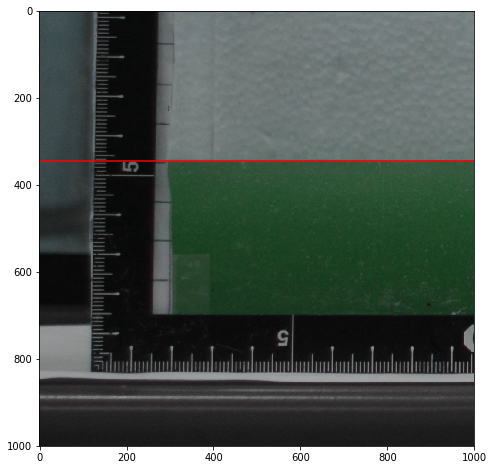

In [152]:
# Change these parameters
filedir = # path to file
filename = # file name of side photo

# Crop image
top = 2000
bottom = 3000

left = 500
right = 1500

base = 1.27 # channel base thickness in cm

# Load and plot
img = cv2.imread(filedir + filename) 

fig, ax = plt.subplots(figsize=(12,8))
plt.imshow(img[top:bottom, left:right])

# Find top of reservoir
height = 345
plt.plot([0, right-left-1], [height, height],'r')

# Reservoir depth
H = (5.35 - base)/100 # in m

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in power


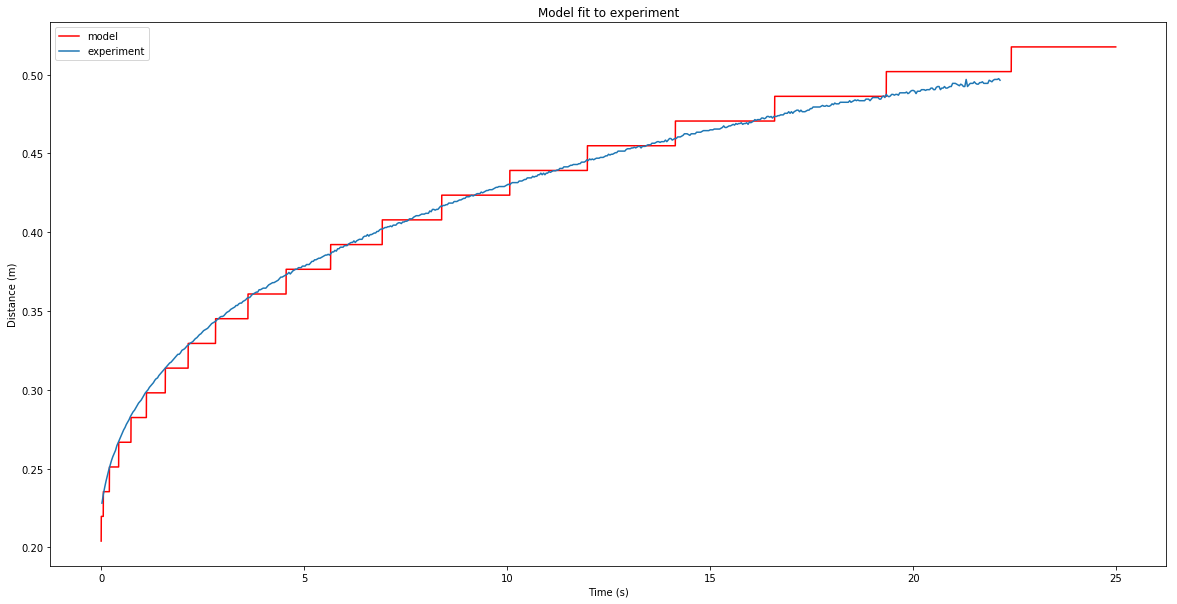

In [210]:
# Simulate video
#H = 0.016 # reservoir height in m
L = 0.2  # reservoir length in m
#K = 8.9 # consistency in Pas
rho = 1540 # density in kg/m^3
g = 9.81   # gravitational acceleration m/s^2
ts = t_scaled[-1] # time in s
#n = 0.8 # power law exponent
#tauy = 0 # yield stress Pa
theta = 0 # slope in degrees

# Discretize domain 
m = 50
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

# Number of time steps
i = 25000

# Initial condition
h0 = np.zeros_like(x)
h0[x<L] = H

# Solve
h, t = damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i)

# Initialize front location
X = np.zeros_like(t)

threshold = 0.0001
for j in np.arange(h.shape[0]):
    X[j] = x[np.max(np.nonzero(h[j,:]>threshold)) + 1] # find node with h>threshold


# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t,X,'r-',label='model');
ax.plot(t_scaled[t_scaled>t0]-t0,pos_scaled[t_scaled>t0]+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

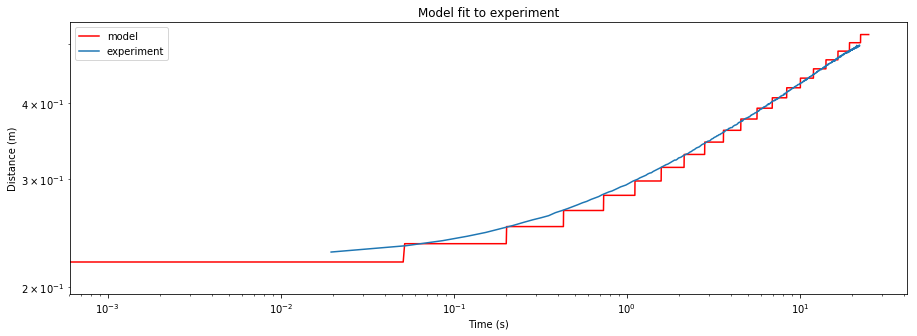

In [167]:
# Plot data and fitting parameters

fig,ax = plt.subplots(figsize=(15,5))
ax.loglog(t,X,'r-',label='model');
ax.loglog(t_scaled[t_scaled>t0]-t0,pos_scaled[t_scaled>t0]+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();